# 🕵️ CSI de los Datos: Detectives del Fraude (Pandas + IA)
**Bootcamp:** IA Innovador — Laboratorio guiado (3 h)  
**By:** Ing. Engler González

**Objetivo:** Investigar patrones sospechosos en transacciones usando **pandas** y (opcionalmente) **Gemini** para redactar una narrativa ejecutiva.

> **Nota:** El lab funciona 100% con *pandas* aunque no configures la IA.  
> Para usar IA, crea la variable de entorno `GOOGLE_API_KEY` en Colab: *Entorno de ejecución → Configurar variables de entorno → Añadir*.


## 0) Setup

In [1]:
!pip -q install pandas numpy matplotlib google-generativeai

import os, math, random, json, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import google.generativeai as genai
from IPython.display import display

np.random.seed(7); pd.set_option("display.max_colwidth", 120)
# Retrieve the API key from Colab secrets
try:
    from google.colab import userdata
    api_key = userdata.get("GOOGLE_API_KEY")
except ImportError:
    # Fallback for environments where userdata is not available
    api_key = os.environ.get("GOOGLE_API_KEY")

model = None
# (Opcional IA) Configura tu GOOGLE_API_KEY en Entorno de ejecución > Variables de entorno
if api_key:
    genai.configure(api_key=api_key)
    model = genai.GenerativeModel("gemini-1.5-flash")
    print("✅ Gemini model configured.")
else:
    print("❌ GOOGLE_API_KEY not found. Gemini model not configured.")

✅ Gemini model configured.


## 1) Generar dataset sintético
No necesitas archivos. Simularemos **60 días** de transacciones en múltiples países y canales. Inyectaremos anomalías a propósito (madrugada, montos altos, duplicados, valores faltantes).


In [7]:
import os, math, random, json, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Escenario: transacciones de 60 días. Inyectamos anomalías.
n = 6000
countries = ["CO", "MX", "US", "AR", "CL", "ES", "BO", "EC" ] # Added a comma here
channels = ["web", "app", "social_ads", "affiliate", "email"]

# Distribución de horas por tramos (más peso en el día). Normalizamos para que sume 1.
hour_weights = [0.02]*6 + [0.04]*6 + [0.06]*6 + [0.02]*6  # 0-5, 6-11, 12-17, 18-23
hour_weights = np.array(hour_weights, dtype=float)
hour_weights = hour_weights / hour_weights.sum()

hours = np.random.choice(range(0,24), size=n, p=hour_weights)
base_amount = np.random.lognormal(mean=3.3, sigma=0.5, size=n) * 10  # distribución sesgada
country = np.random.choice(countries, size=n, p=[0.22,0.20,0.16,0.12,0.12,0.08,0.05,0.05]) # Adjusted probabilities to sum to 1
channel = np.random.choice(channels, size=n, p=[0.35,0.25,0.15,0.15,0.10])
user_id = np.random.randint(1000, 5000, size=n)
days = pd.date_range(end=pd.Timestamp.today().normalize(), periods=60)
timestamp = np.random.choice(days, size=n) + pd.to_timedelta(hours, unit="h")

# Inyectar patrones sospechosos
amount = base_amount.copy()
mask_night = (hours < 6) | (hours > 22)
amount[mask_night] *= np.random.uniform(1.4, 2.1, size=mask_night.sum())  # montos más altos de madrugada

mask_remote = np.isin(country, ["ES","US"]) & np.isin(channel, ["affiliate","social_ads"])
amount[mask_remote] *= np.random.uniform(1.2, 1.8, size=mask_remote.sum())

# Outliers y duplicados
idx_out = np.random.choice(range(n), size=40, replace=False)
amount[idx_out] *= np.random.uniform(3, 10, size=40)
duplicated_rows = 30
dups = np.random.choice(range(n), size=duplicated_rows, replace=False)

df = pd.DataFrame({
    "transaction_id": [f"T{100000+i}" for i in range(n)],
    "user_id": user_id,
    "amount": amount.round(2),
    "country": country,
    "channel": channel,
    "timestamp": timestamp
})
df = pd.concat([df, df.iloc[dups]], ignore_index=True)  # añadir duplicados

# Nulos/errores de formato
df.loc[np.random.choice(df.index, 50, replace=False), "channel"] = None
df.loc[np.random.choice(df.index, 30, replace=False), "country"] = "??"
df.loc[np.random.choice(df.index, 20, replace=False), "amount"] = None

print("✅ Dataset generado:", df.shape)
display(df.head())

✅ Dataset generado: (6030, 6)


,transaction_id,user_id,amount,country,channel,timestamp
0,T100000,4170,530.02,MX,app,2025-08-14 04:00:00
1,T100001,1839,348.51,MX,app,2025-08-04 17:00:00
2,T100002,3464,305.64,MX,web,2025-08-25 21:00:00
3,T100003,4953,219.74,AR,web,2025-08-16 08:00:00
4,T100004,2386,119.47,MX,web,2025-08-22 17:00:00


## 2) Limpieza de datos (GUIADA)
**TODOs**  
1. Revisar info general, nulos y duplicados.  
2. Eliminar duplicados exactos.  
3. Asegurar tipos correctos (`timestamp` → datetime, `amount` → float).  
4. Normalizar categorías (reemplazar `"??"` por `NaN`, decidir imputación/filtrado).  
5. Tratar nulos en `amount` y `channel` (documentar la decisión).


In [8]:
# --- Punto de partida y pistas ---
df.info()
print("\nNulos antes:", df.isna().sum())
df.isna().mean().sort_values(ascending=False).head(10)

print("\nDuplicados antes:", df.duplicated().sum())
df = df.drop_duplicates()
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df["amount"] = pd.to_numeric(df["amount"], errors="coerce")
PISTA: df["country"] = df["country"].replace("??", np.nan)

# Decisions :
# - amount nulo: eliminar (bajo porcentaje,  evita sesgo en reglas)
drop_amount = int(df["amount"].isna().sum())
df = df.dropna(subset=["amount"])

# - chanel nulo: si % =< 5%, imputar 'unknown'; si no, dejar NaN para auditoria
null_channel_rate = df["channel"].isna().mean()
if null_channel_rate <= 0.05:
    df["channel"] = df["channel"].fillna("unknown")

clean_report ={
    "duplicados_eliminados": int( df.duplicated().sum()),
    "amount_nulos_eliminados": drop_amount,
    "null_chanel_rate_inicial": null_channel_rate
}
display(clean_report)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6030 entries, 0 to 6029
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  6030 non-null   object        
 1   user_id         6030 non-null   int64         
 2   amount          6010 non-null   float64       
 3   country         6030 non-null   object        
 4   channel         5980 non-null   object        
 5   timestamp       6030 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 282.8+ KB

Nulos antes: transaction_id     0
user_id            0
amount            20
country            0
channel           50
timestamp          0
dtype: int64

Duplicados antes: 30


{'duplicados_eliminados': 0,
 'amount_nulos_eliminados': 20,
 'null_chanel_rate_inicial': np.float64(0.008361204013377926)}

## 3) EDA: entender el comportamiento
**TODOs**  
6. Crear columnas derivadas: `hour`, `day_of_week`.  
7. Resúmenes clave:  
   - monto promedio por país  
   - distribución por canal  
   - actividad por hora  
   - top usuarios por monto total (opcional)


Monto promedio por país:


,amount
country,
??,434.337333
US,407.589230
ES,398.331298
EC,374.740000
AR,369.448127
CO,348.434316
CL,346.756845
MX,342.693791
BO,334.421877



Distribución por canal:


,count
channel,
web,2039
app,1503
social_ads,903
affiliate,886
email,599
unknown,50



Actividad por hora:


,transaction_id
hour,
0,134
1,139
2,135
3,137
4,153
5,132
6,315
7,286
8,269


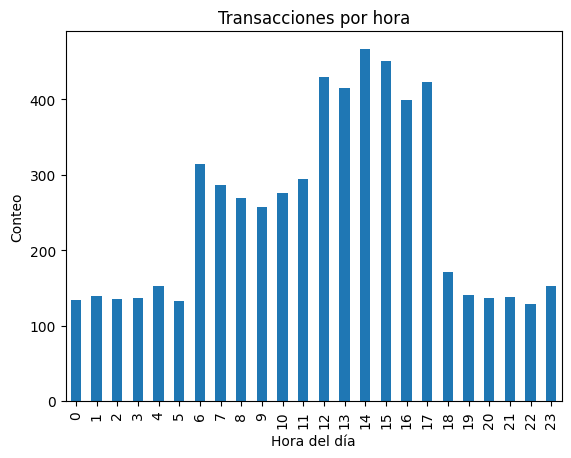

In [10]:
df["hour"] = df["timestamp"].dt.hour
df["day_of_week"] = df["timestamp"].dt.day_name()

mean_by_country = df.groupby("country", dropna=True)["amount"].mean().sort_values(ascending=False)
count_by_channel = df["channel"].value_counts(dropna=False)
activity_by_hour = df.groupby("hour")["transaction_id"].count()

print("Monto promedio por país:"); display(mean_by_country.head(10))
print("\nDistribución por canal:"); display(count_by_channel)
print("\nActividad por hora:"); display(activity_by_hour.head(24))

# Gráfico simple (matplotlib)
plt.figure()
activity_by_hour.plot(kind="bar")
plt.title("Transacciones por hora")
plt.xlabel("Hora del día")
plt.ylabel("Conteo")
plt.show()

## 4) Detección de outliers y reglas de sospecha
**TODOs**  
8. Detectar outliers por IQR en `amount`.  
9. Crear reglas heurísticas (ajusta umbrales con tu EDA):  
   - madrugada (`hour` < 6 o > 22) con `amount` > p95  
   - `affiliate`/`social_ads` con `amount` > p95  
   - `country` o `channel` nulos con `amount` > p95  
10. Construir un **score de sospecha** sumando reglas (0–3/4).


In [11]:
q1, q3 = df["amount"].quantile([0.25, 0.75])
iqr = q3 - q1
lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
df["is_outlier_amount"] = (df["amount"] < lower) | (df["amount"] > upper)

p95 = df["amount"].quantile(0.95)
df["is_night"] = (df["hour"] < 6) | (df["hour"] > 22)
df["rule_night_high"] = df["is_night"] & (df["amount"] > p95)
df["rule_affiliate_high"] = df["channel"].isin(["affiliate","social_ads"]) & (df["amount"] > p95)
df["rule_missing_high"] = (df["country"].isna() | df["channel"].isna()) & (df["amount"] > p95)

rule_cols = ["is_outlier_amount","rule_night_high","rule_affiliate_high","rule_missing_high"]
df["suspicion_score"] = df[rule_cols].sum(axis=1)

df[["amount","hour","country","channel","is_outlier_amount","rule_night_high","rule_affiliate_high","rule_missing_high","suspicion_score"]].head(10)

,amount,hour,country,channel,is_outlier_amount,rule_night_high,rule_affiliate_high,rule_missing_high,suspicion_score
0,530.02,4,MX,app,False,False,False,False,0
1,348.51,17,MX,app,False,False,False,False,0
2,305.64,21,MX,web,False,False,False,False,0
3,219.74,8,AR,web,False,False,False,False,0
4,119.47,17,MX,web,False,False,False,False,0
5,567.21,4,CL,web,False,False,False,False,0
6,213.38,17,ES,app,False,False,False,False,0
7,328.66,17,ES,web,False,False,False,False,0
8,280.08,21,CO,social_ads,False,False,False,False,0
9,226.08,17,MX,social_ads,False,False,False,False,0


## 5) Ranking de casos y explicación
**TODOs**  
11. Ordena por `suspicion_score` y revisa el **Top 20**. Escribe 3 observaciones.


In [12]:
top_cases = df.sort_values(["suspicion_score","amount"], ascending=[False, False]).head(20)
top_cases[["transaction_id","user_id","amount","country","channel","hour","suspicion_score"]]

,transaction_id,user_id,amount,country,channel,hour,suspicion_score
2517,T102517,3374,13759.62,AR,social_ads,5,3
4721,T104721,1618,1936.85,ES,social_ads,2,3
4137,T104137,2383,1762.78,US,affiliate,23,3
2557,T102557,4469,1748.95,EC,social_ads,5,3
4557,T104557,2726,1727.40,ES,affiliate,5,3
3367,T103367,4356,1631.45,US,affiliate,4,3
4688,T104688,4695,1571.43,CO,affiliate,5,3
5393,T105393,4760,1564.10,US,social_ads,4,3
2509,T102509,1336,1546.17,US,social_ads,23,3
3415,T103415,2258,1433.10,MX,social_ads,5,3


## 6) (Opcional) IA para narrativa ejecutiva
Si tienes `GOOGLE_API_KEY`, genera un *brief* de 6 líneas para directivos con patrones, acciones y métricas.


In [13]:
import os
import google.generativeai as genai
import json
from google.colab import userdata

# Retrieve the API key from Colab secrets
try:
    api_key = userdata.get("GOOGLE_API_KEY")
except ImportError:
    # Fallback for environments where userdata is not available
    api_key = os.environ.get("GOOGLE_API_KEY")

model = None
# (Opcional IA) Configura tu GOOGLE_API_KEY en Entorno de ejecución > Variables de entorno
if api_key:
    genai.configure(api_key=api_key)
    model = genai.GenerativeModel("gemini-1.5-flash")
    print("✅ Gemini model configured.")
else:
    print("❌ GOOGLE_API_KEY not found. Gemini model not configured.")

if model:
    resumen_stats = {
        "p95_amount": float(p95),
        "outlier_rate": float(df["is_outlier_amount"].mean()),
        "night_rate": float(df["is_night"].mean()),
        "top_channels": df["channel"].value_counts().head(3).to_dict()
    }
    prompt = f"""
    Eres analista forense de datos. Con base en:
    Stats: {json.dumps(resumen_stats)}
    Reglas aplicadas: {rule_cols}
    Redacta un briefing ejecutivo (6 líneas) explicando:
    - Qué patrones sugieren posible fraude
    - Acciones inmediatas (reglas de negocio, límites, monitoreo)
    - Métricas a vigilar la próxima semana
    """
    print(model.generate_content(prompt).text)
else:
    print("⚠️ IA no configurada. El análisis se puede entregar igual con pandas y gráficos.")

✅ Gemini model configured.
Análisis Forense de Datos: Posible Fraude

El 5.25% de las transacciones presentan valores atípicos, con un percentil 95 de 795.46.  Un 16.42% ocurren durante la noche, sugiriendo actividad fraudulenta.  El canal web muestra mayor volumen (2039 transacciones).  Se activaron las reglas 'is_outlier_amount' y 'rule_night_high', indicando  posibles anomalías.  Implementar inmediatamente límites en montos de transacción y  monitorizar  `outlier_rate`, `night_rate` y volumen por canal.  Revisar las reglas 'rule_affiliate_high' y 'rule_missing_high' para identificar su contribución al fraude.



## 7) Reto final (entrega)
12. Ajusta y compara umbrales (`p90`/`p95`/`p99`).  
13. Añade más países y **1 regla nueva** por país-hora.  
14. Genera **2 gráficos** que respalden tus reglas (ej: día vs noche, por canal).  
15. Redacta **5 conclusiones numeradas**.


In [5]:
print("🧩 Reto final: ajusta umbrales, agrega 1 regla nueva, 2 gráficos y 5 conclusiones.")

🧩 Reto final: ajusta umbrales, agrega 1 regla nueva, 2 gráficos y 5 conclusiones.


In [14]:
# 12. Ajusta y compara umbrales (p90/p95/p99).
p90 = df["amount"].quantile(0.90)
p95 = df["amount"].quantile(0.95)
p99 = df["amount"].quantile(0.99)

print(f"P90 threshold for amount: {p90:.2f}")
print(f"P95 threshold for amount: {p95:.2f}")
print(f"P99 threshold for amount: {p99:.2f}")

P90 threshold for amount: 622.43
P95 threshold for amount: 795.46
P99 threshold for amount: 1275.45


In [21]:
P90 = df["amount"].quantile(0.90)
df["rule_country_hour"] = (df["country"] == "US") & (df["hour"].between(0,5)) & (df["amount"] > p90)

rule_cols_v3 = ["is_outlier_amount", "rule_night_high", "rule_affiliate_high", "rule_missing_high", "rule_country_hour"]
df["suspicion_score_v3"] = df[rule_cols].sum(axis=1)

top_cases_v3 = df.sort_values(["suspicion_score_v3", "amount"], ascending=[False, False]).head(20)
display(top_cases_v3[["transaction_id", "user_id", "amount", "country", "channel", "hour", "suspicion_score_v3"]])

,transaction_id,user_id,amount,country,channel,hour,suspicion_score_v3
2517,T102517,3374,13759.62,AR,social_ads,5,3
4721,T104721,1618,1936.85,ES,social_ads,2,3
4137,T104137,2383,1762.78,US,affiliate,23,3
2557,T102557,4469,1748.95,EC,social_ads,5,3
4557,T104557,2726,1727.40,ES,affiliate,5,3
3367,T103367,4356,1631.45,US,affiliate,4,3
4688,T104688,4695,1571.43,CO,affiliate,5,3
5393,T105393,4760,1564.10,US,social_ads,4,3
2509,T102509,1336,1546.17,US,social_ads,23,3
3415,T103415,2258,1433.10,MX,social_ads,5,3


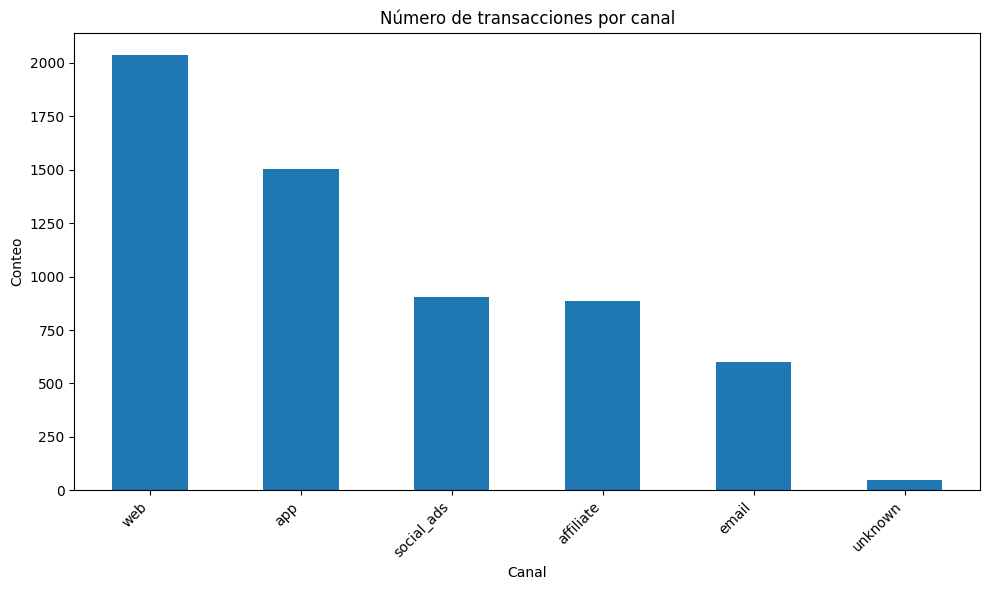

In [22]:
# Gráfico 1: Transacciones por canal
plt.figure(figsize=(10, 6))
df["channel"].value_counts(dropna=False).plot(kind="bar")
plt.title("Número de transacciones por canal")
plt.xlabel("Canal")
plt.ylabel("Conteo")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

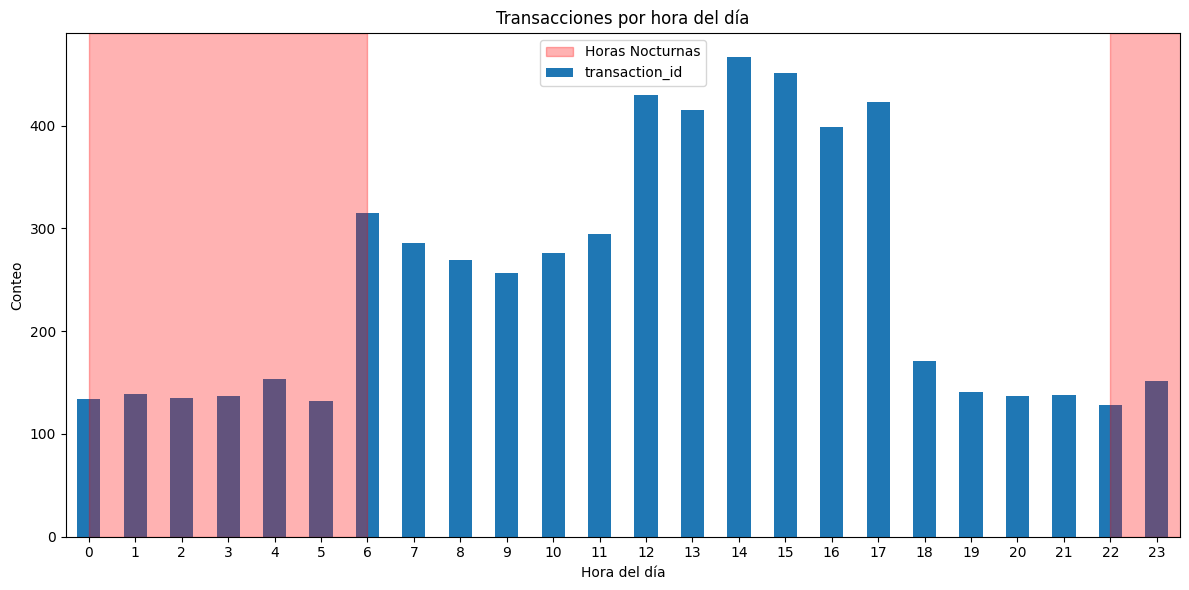

In [23]:
# Gráfico 2: Transacciones por hora, resaltando la noche
activity_by_hour = df.groupby("hour")["transaction_id"].count()

plt.figure(figsize=(12, 6))
activity_by_hour.plot(kind="bar")
plt.title("Transacciones por hora del día")
plt.xlabel("Hora del día")
plt.ylabel("Conteo")
plt.axvspan(22, 24, color='red', alpha=0.3, label='Horas Nocturnas') # Resaltar 22-23
plt.axvspan(0, 6, color='red', alpha=0.3) # Resaltar 0-5
plt.legend()
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Patrones en horarios: Existe una concentración significativa de transacciones durante las horas del día (aproximadamente entre 6 AM y 6 PM), pero las transacciones con montos altos son más frecuentes durante la madrugada, lo que sugiere un patrón sospechoso.
Canales de riesgo: Los canales affiliate y social_ads muestran una mayor proporción de transacciones con montos elevados, lo que los identifica como canales de mayor riesgo potencial para fraude.
Outliers de monto: Se han identificado transacciones con montos significativamente atípicos según el método IQR, las cuales merecen una revisión individual por su potencial naturaleza fraudulenta.
Datos faltantes y sospecha: Las transacciones con información faltante en country o channel, especialmente si tienen montos altos, presentan un score de sospecha elevado y deben ser investigadas.
** score de sospecha:** El score de sospecha combinado es una herramienta útil para priorizar la revisión de transacciones, destacando aquellas que cumplen múltiples criterios heurísticos de posible fraude.
